In [1]:
import time
start = time.time()

import pandas as pd # dataframes
import numpy as np # algebra & calculus
import gc #clean-up memory
import os
import numpy as np
from operator import itemgetter
import pandas as pd
import multiprocessing as mp
import time
import xgboost
from sklearn.model_selection import train_test_split

In [9]:
uxp = pd.read_pickle('uxp.pkl')
#uxp = uxp.iloc[0:150000]
uxp.head()

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5_x,times_last5_ratio_x,times_last5_y,times_last5_ratio_y,Times_Bought_N_x,total_orders_x,...,Order_Range_D_y,Order_Ratio_user_id_X_product_id_y,reorder_ratio,mean_add_to_cart_order,item_first_ratio,item_N2_ratio,item_N3_ratio,item_N4_ratio,item_N5_ratio,order_size_avg
0,1,196.0,10,0.417500,4.0,0.8,4.0,0.8,10,11,...,11,0.909091,0.776480,3.721774,0.049538,1.0,1.0,1.0,1.0,5.363636
1,1,10258.0,9,0.447038,4.0,0.8,4.0,0.8,9,11,...,10,0.900000,0.713772,4.277492,0.025180,1.0,1.0,1.0,1.0,5.363636
2,1,10326.0,1,0.478419,NaN,NaN,NaN,NaN,1,11,...,7,0.142857,0.652009,4.191097,0.020449,1.0,1.0,1.0,1.0,5.363636
3,1,12427.0,10,0.470518,4.0,0.8,4.0,0.8,10,11,...,11,0.909091,0.740735,4.760037,0.028567,1.0,1.0,1.0,1.0,5.363636
4,1,13032.0,3,0.520218,2.0,0.4,2.0,0.4,3,11,...,10,0.300000,0.657158,5.622767,0.009064,1.0,1.0,1.0,1.0,5.363636


In [10]:
orders = pd.read_csv('orders.csv/orders.csv' )
order_products_train = pd.read_csv('order_products__train.csv/order_products__train.csv')

In [11]:
orders_last = orders[(orders.eval_set=='train') | (orders.eval_set=='test') ]

In [12]:
uxp = uxp.merge(orders_last, on='user_id', how='left')
uxp.head(10)

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5_x,times_last5_ratio_x,times_last5_y,times_last5_ratio_y,Times_Bought_N_x,total_orders_x,...,item_N3_ratio,item_N4_ratio,item_N5_ratio,order_size_avg,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,196.0,10,0.417500,4.0,0.8,4.0,0.8,10,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
1,1,10258.0,9,0.447038,4.0,0.8,4.0,0.8,9,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
2,1,10326.0,1,0.478419,NaN,NaN,NaN,NaN,1,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
3,1,12427.0,10,0.470518,4.0,0.8,4.0,0.8,10,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
4,1,13032.0,3,0.520218,2.0,0.4,2.0,0.4,3,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
5,1,13176.0,2,0.288116,NaN,NaN,NaN,NaN,2,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
6,1,14084.0,1,0.370850,NaN,NaN,NaN,NaN,1,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
7,1,17122.0,1,0.472574,NaN,NaN,NaN,NaN,1,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
8,1,25133.0,8,0.419255,4.0,0.8,4.0,0.8,8,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0
9,1,26088.0,2,0.595013,NaN,NaN,NaN,NaN,2,11,...,1.0,1.0,1.0,5.363636,1187899,train,11,4,8,14.0


In [13]:
uxp_train = uxp[uxp.eval_set=='train']

uxp_train = uxp_train.merge(order_products_train, on=['product_id', 'order_id'], how='left' )

uxp_train = uxp_train.drop(['order_id','eval_set', 'add_to_cart_order'], axis=1)
uxp_train = uxp_train.fillna(0)
uxp_train.head(20)

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5_x,times_last5_ratio_x,times_last5_y,times_last5_ratio_y,Times_Bought_N_x,total_orders_x,...,item_N2_ratio,item_N3_ratio,item_N4_ratio,item_N5_ratio,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196.0,10,0.417500,4.0,0.8,4.0,0.8,10,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,1.0
1,1,10258.0,9,0.447038,4.0,0.8,4.0,0.8,9,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,1.0
2,1,10326.0,1,0.478419,0.0,0.0,0.0,0.0,1,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,0.0
3,1,12427.0,10,0.470518,4.0,0.8,4.0,0.8,10,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,0.0
4,1,13032.0,3,0.520218,2.0,0.4,2.0,0.4,3,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,1.0
5,1,13176.0,2,0.288116,0.0,0.0,0.0,0.0,2,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,0.0
6,1,14084.0,1,0.370850,0.0,0.0,0.0,0.0,1,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,0.0
7,1,17122.0,1,0.472574,0.0,0.0,0.0,0.0,1,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,0.0
8,1,25133.0,8,0.419255,4.0,0.8,4.0,0.8,8,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,1.0
9,1,26088.0,2,0.595013,0.0,0.0,0.0,0.0,2,11,...,1.0,1.0,1.0,1.0,5.363636,11,4,8,14.0,1.0


In [14]:
uxp_test = uxp[uxp.eval_set=='test']
uxp_test = uxp_test.drop(['eval_set', 'order_id'], axis=1)
uxp_test = uxp_test.fillna(0)
uxp_test.head(20)

,user_id,product_id,uxp_total_bought,one_shot_ratio_product,times_last5_x,times_last5_ratio_x,times_last5_y,times_last5_ratio_y,Times_Bought_N_x,total_orders_x,...,item_first_ratio,item_N2_ratio,item_N3_ratio,item_N4_ratio,item_N5_ratio,order_size_avg,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248.0,1,0.720492,0.0,0.0,0.0,0.0,1,13,...,0.000314,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
121,3,1005.0,1,0.687259,1.0,0.2,1.0,0.2,1,13,...,0.002160,1.0,0.0,0.0,0.0,6.769231,13,5,15,11.0
122,3,1819.0,3,0.653128,0.0,0.0,0.0,0.0,3,13,...,0.000825,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
123,3,7503.0,1,0.616269,0.0,0.0,0.0,0.0,1,13,...,0.002004,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
124,3,8021.0,1,0.559164,0.0,0.0,0.0,0.0,1,13,...,0.001543,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
125,3,9387.0,5,0.530830,0.0,0.0,0.0,0.0,5,13,...,0.006190,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
126,3,12845.0,1,0.742956,0.0,0.0,0.0,0.0,1,13,...,0.000598,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
127,3,14992.0,2,0.572936,0.0,0.0,0.0,0.0,2,13,...,0.001273,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
128,3,15143.0,1,0.641919,0.0,0.0,0.0,0.0,1,13,...,0.002031,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0
129,3,16797.0,3,0.433382,1.0,0.2,1.0,0.2,3,13,...,0.005911,1.0,1.0,1.0,1.0,6.769231,13,5,15,11.0


In [15]:
del uxp
del orders_last
gc.collect()

120

In [16]:
uxp_train = uxp_train.set_index(['user_id', 'product_id'])

uxp_test = uxp_test.set_index(['user_id', 'product_id'])

[01:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { binary, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-logloss:0.66536
[2]	train-logloss:0.65268
[3]	train-logloss:0.63993
[4]	train-logloss:0.62782
[6]	train-logloss:0.60488
[7]	train-logloss:0.59399
[8]	train-logloss:0.58354
[9]	train-logloss:0.57351
[11]	train-logloss:0.55422
[12]	train-logloss:0.54524
[13]	train-logloss:0.53643
[14]	train-logloss:0.52798
[16]	train-logloss:0.51193
[17]	train-logloss:0.50417
[18]	train-logloss:0.49682
[19]	train-logloss:0.48959
[21]	train-logloss:0.47590
[22]	train-logloss:0.46936
[23]	train-logloss:0.46301
[24]	train-logloss:0.45685
[26]	train-logloss:0.44510
[27]	train-logloss:0.43948
[28]	train-logloss:0.4

[353]	train-logloss:0.24288
[354]	train-logloss:0.24287
[356]	train-logloss:0.24285
[357]	train-logloss:0.24284
[358]	train-logloss:0.24284
[359]	train-logloss:0.24283
[361]	train-logloss:0.24281
[362]	train-logloss:0.24280
[363]	train-logloss:0.24280
[364]	train-logloss:0.24279
[366]	train-logloss:0.24277
[367]	train-logloss:0.24276
[368]	train-logloss:0.24275
[369]	train-logloss:0.24274
[371]	train-logloss:0.24271
[372]	train-logloss:0.24271
[373]	train-logloss:0.24269
[374]	train-logloss:0.24268
[376]	train-logloss:0.24266
[377]	train-logloss:0.24266
[378]	train-logloss:0.24265
[379]	train-logloss:0.24263
[381]	train-logloss:0.24262
[382]	train-logloss:0.24261
[383]	train-logloss:0.24260
[384]	train-logloss:0.24259
[386]	train-logloss:0.24257
[387]	train-logloss:0.24256
[388]	train-logloss:0.24255
[389]	train-logloss:0.24254
[391]	train-logloss:0.24252
[392]	train-logloss:0.24251
[393]	train-logloss:0.24250
[394]	train-logloss:0.24249
[396]	train-logloss:0.24247
[397]	train-logloss:

[719]	train-logloss:0.23997
[721]	train-logloss:0.23996
[722]	train-logloss:0.23996
[723]	train-logloss:0.23995
[724]	train-logloss:0.23994
[726]	train-logloss:0.23992
[727]	train-logloss:0.23992
[728]	train-logloss:0.23991
[729]	train-logloss:0.23990
[731]	train-logloss:0.23989
[732]	train-logloss:0.23988
[733]	train-logloss:0.23988
[734]	train-logloss:0.23987
[736]	train-logloss:0.23985
[737]	train-logloss:0.23985
[738]	train-logloss:0.23985
[739]	train-logloss:0.23984
[741]	train-logloss:0.23983
[742]	train-logloss:0.23982
[743]	train-logloss:0.23981
[744]	train-logloss:0.23980
[746]	train-logloss:0.23979
[747]	train-logloss:0.23978
[748]	train-logloss:0.23978
[749]	train-logloss:0.23977
[751]	train-logloss:0.23977
[752]	train-logloss:0.23976
[753]	train-logloss:0.23975
[754]	train-logloss:0.23975
[756]	train-logloss:0.23974
[757]	train-logloss:0.23973
[758]	train-logloss:0.23972
[759]	train-logloss:0.23972
[761]	train-logloss:0.23971
[762]	train-logloss:0.23970
[763]	train-logloss:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

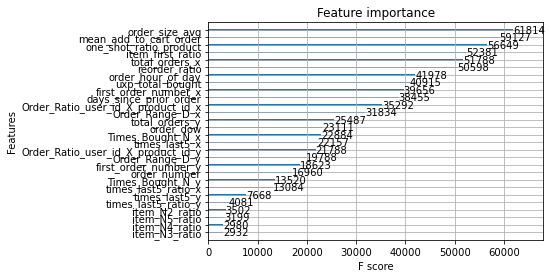

In [17]:
uxp_train.loc[:, 'reordered'] = uxp_train.reordered.fillna(0)


# subsample
X_train, X_val, y_train, y_val = train_test_split(uxp_train.drop('reordered', axis=1), uxp_train.reordered,
                                                    test_size=0.2, random_state=42)

'''del uxp_train'''
gc.collect()

d_train = xgboost.DMatrix(X_train, y_train)
param = {'max_depth':10, 
         'eta':0.02,
         'colsample_bytree':0.4,
         'subsample':0.75,
         'silent':1,
         'nthread':27,
         'eval_metric':'logloss',
         'binary':'logistic',
         'tree_method':'hist'
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=param, dtrain=d_train, num_boost_round=1000, evals=watchlist, early_stopping_rounds=40, verbose_eval=5)
xgboost.plot_importance(bst)


In [21]:
del [X_train, X_val, y_train, y_val]
gc.collect()

35

In [21]:
d_test = xgboost.DMatrix(uxp_test)

uxp_test = uxp_test.reset_index()
uxp_test = uxp_test[['product_id', 'user_id']]

uxp_test["reordered"] = bst.predict(d_test)

del bst


In [22]:
orders_test = orders[orders.eval_set=='test']

In [23]:
uxp_test = uxp_test.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left').drop('user_id', axis=1)
uxp_test.columns = ['product_id', 'prediction', 'order_id']
uxp_test.product_id = uxp_test.product_id.astype(int)
uxp_test.order_id = uxp_test.order_id.astype(int)
uxp_test.head()


,product_id,prediction,order_id
0,248,0.015437,2774568
1,1005,0.045790,2774568
2,1819,0.088633,2774568
3,7503,0.021548,2774568
4,8021,0.026182,2774568


In [24]:
del orders
del orders_test
gc.collect()

111

In [25]:
class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)


def get_best_prediction(items, preds, pNone=None):
#    print("Maximize F1-Expectation")
#    print("=" * 23)
    items_preds = sorted(list(zip(items, preds)), key=itemgetter(1), reverse=True)
    P = [p for i,p in items_preds]
    L = [i for i,p in items_preds]
    
    opt = F1Optimizer.maximize_expectation(P)
    best_prediction = []
    best_prediction += (L[:opt[0]])
    if best_prediction == []:
        best_prediction = ['None']
            
#    print("Prediction {} yields best E[F1] of {}\n".format(best_prediction, f1_max))
    return ' '.join(list(map(str,best_prediction)))


In [26]:
uxp_test.to_csv('uxp_test.csv')

In [34]:
import pandas

uxp_test = pandas.read_csv('uxp_test.csv')

In [35]:
sub_item = uxp_test.groupby(['order_id','product_id']).prediction.mean().reset_index()
sub = sub_item.groupby('order_id').product_id.apply(list).to_frame()
sub['yhat'] = sub_item.groupby('order_id').prediction.apply(list)
sub.reset_index(inplace=True)
sub.set_index('order_id', inplace = True)

In [ ]:
del uxp_test, sub_item
gc.collect()

def multi(i):
    print(i)
    items = sub.loc[i][0]
    preds = sub.loc[i][1]
    ret = get_best_prediction(items, preds)
    return ret

In [40]:
sub.tail()

,product_id,yhat
order_id,,
3420740,"[260, 581, 809, 1015, 1158, 1402, 1468, 2094, ...","[0.046773717, 0.012867617, 0.00586608400000000..."
3420877,"[274, 343, 651, 890, 1000, 1244, 1529, 2077, 2...","[0.020941381999999998, 0.017097667, 0.02190896..."
3420888,"[2361, 7021, 7963, 8193, 8424, 10111, 10880, 1...","[0.5215147, 0.03473184, 0.3502575, 0.049229313..."
3420989,"[2180, 5134, 7781, 8151, 8277, 8555, 8865, 135...","[0.045884732000000004, 0.14546561, 0.0923125, ..."
3421054,"[4769, 5818, 5976, 7644, 7925, 8580, 9837, 103...","[0.039231777, 0.19829008, 0.047272302, 0.07464..."


In [ ]:
callback = []

st_time = time.time()

for i in sub.index:
    callback.append(multi(i))
    
sub['products'] = callback
sub.head()

sub.to_csv('sub.csv')

In [41]:
pandas.read_csv('sub.csv')

,order_id,product_id,yhat,products
0,17,"[1283, 6291, 7035, 11494, 13107, 13535, 15613,...","[0.015190503999999999, 0.07601458, 0.04160486,...",13107 21463 39275 38777 47766
1,34,"[651, 2361, 2596, 4031, 5134, 5242, 6317, 7035...","[0.02362709, 0.03523935, 0.26062527, 0.0031976...",16083 39475 43504 47766 21137 2596 47792 44663...
2,137,"[311, 1335, 2078, 2326, 2661, 3951, 5025, 5114...","[0.04267144, 0.025145462, 0.045293096, 0.25092...",38689 24852 23794 41787 2326 25890 5134
3,182,"[1244, 1757, 2078, 2295, 2480, 3397, 4344, 442...","[0.05602287, 0.024499087000000003, 0.09333142,...",9337 5479 13629 39275 47672 47209 11520 33000 ...
4,257,"[1025, 2063, 2309, 4605, 4683, 6795, 8277, 103...","[0.19178842, 0.12623599, 0.025104176000000002,...",24852 49235 29837 27966 39475 27104 37646 2847...
...,...,...,...,...
74995,3420740,"[260, 581, 809, 1015, 1158, 1402, 1468, 2094, ...","[0.046773717, 0.012867617, 0.00586608400000000...",35951 19660 46252 49005 39146 28476 8174 48070...
74996,3420877,"[274, 343, 651, 890, 1000, 1244, 1529, 2077, 2...","[0.020941381999999998, 0.017097667, 0.02190896...",21137 13646 49111 8277 5161 27966 13176 12238 ...
74997,3420888,"[2361, 7021, 7963, 8193, 8424, 10111, 10880, 1...","[0.5215147, 0.03473184, 0.3502575, 0.049229313...",10880 44632 35951 2361 7963 22935
74998,3420989,"[2180, 5134, 7781, 8151, 8277, 8555, 8865, 135...","[0.045884732000000004, 0.14546561, 0.0923125, ...",47766 46676 42450 35004 13517 47229 43210 3016...
